In [1]:
%matplotlib inline
import torch
import torchvision
from torch import nn
from d2l import torch as d2l

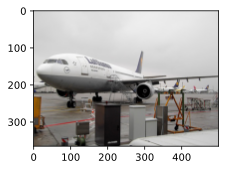

In [2]:
d2l.set_figsize()
img = d2l.Image.open('../../data/VOC2012/JPEGImages/2007_000033.jpg')
d2l.plt.imshow(img)

In [3]:
def apply(img, aug, num_rows=2, num_cols=4, scale=1.5):
    Y = [aug(img) for _ in range(num_rows * num_cols)]
    d2l.show_images(imgs=Y, num_rows=num_rows, num_cols=num_cols, scale=scale)

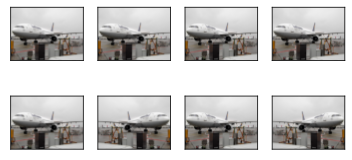

In [4]:
# 水平翻转
apply(img, torchvision.transforms.RandomHorizontalFlip())

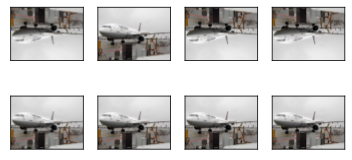

In [5]:
# 垂直翻转
apply(img, torchvision.transforms.RandomVerticalFlip())

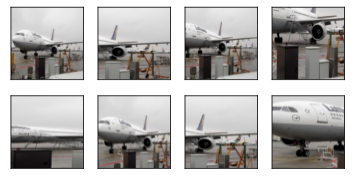

In [6]:
# 随机剪裁
shape_aug = torchvision.transforms.RandomResizedCrop(
    size=(200, 200),
    scale=(0.1, 1),
    ratio=(0.1, 2)
)
apply(img, shape_aug)

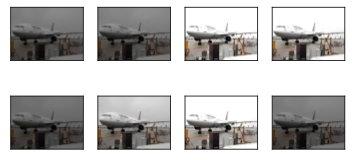

In [7]:
# 随机亮度
apply(img, torchvision.transforms.ColorJitter(brightness=0.5, contrast=0, saturation=0, hue=0))

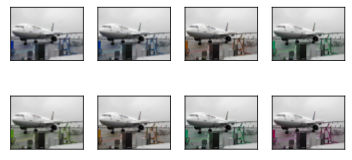

In [8]:
# 随机色温
apply(img, torchvision.transforms.ColorJitter(brightness=0, contrast=0, saturation=0, hue=0.5))

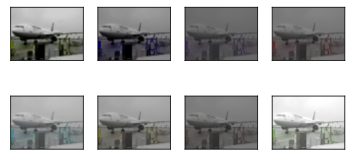

In [9]:
# 一起改
color_aug = torchvision.transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5)
apply(img, color_aug)

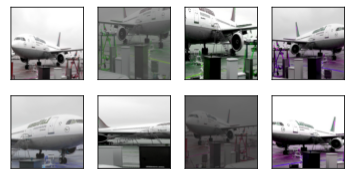

In [10]:
augs = torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(),
    color_aug,
    shape_aug
])
apply(img, augs)

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
      dtype=object)

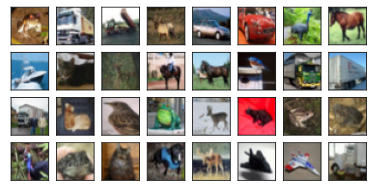

In [11]:
all_images = torchvision.datasets.CIFAR10(train=True, root='../../data', download=False)
d2l.show_images([all_images[i][0] for i in range(32)], 4, 8, scale=0.8)

In [12]:
train_augs = torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor()])

test_augs = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
])

In [13]:
def load_cifar10(is_train, augs, batch_size):
    dataset = torchvision.datasets.CIFAR10(
        root='../../data', train=is_train,
        transform=augs, download=False
    )
    dataloader = torch.utils.data.DataLoader(
        dataset, batch_size=batch_size,
        shuffle=is_train, num_workers=4
    )
    return dataloader

In [14]:
def train_batch_ch13(net, X, y, loss, trainer, devices):
    if isinstance(X, list):
        X = [x.to(devices[0]) for x in X]
    else:
        X = X.to(devices[0])
    
    y = y.to(devices[0])
    net.train()
    trainer.zero_grad()
    pred = net(X)
    l = loss(pred, y)
    l.sum().backward()
    trainer.step()
    train_loss_sum = l.sum()
    train_acc_sum = d2l.accuracy(pred, y)
    return train_loss_sum, train_acc_sum

In [15]:
batch_size, devices, net = 256, d2l.try_gpu(), d2l.resnet18(10, 3)

# def init_weights(m):
#     if type(m) in [nn.Linear, nn.Conv2d]:
#         nn.init.xavier_uniform_(m.weight)
# net.apply(init_weights)

In [16]:
def train_with_data_aug(train_augs, test_augs, net, lr=0.001):
    train_iter = load_cifar10(True, train_augs, batch_size)
    test_iter = load_cifar10(False, test_augs, batch_size)
    loss = nn.CrossEntropyLoss(reduction='none')
    trainer = torch.optim.Adam(net.parameters(), lr=lr)
    d2l.train_ch13(net, train_iter, test_iter, loss, trainer, 10, devices)

loss 0.191, train acc 0.934, test acc 0.837
738.1 examples/sec on cuda:0


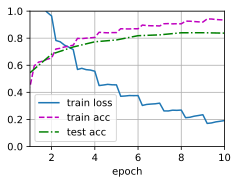

In [17]:
train_with_data_aug(train_augs, test_augs, net)